In [107]:
import pathlib
import pandas as pd

In [108]:
curr_dir = pathlib.Path.cwd()
home_dir = curr_dir.parent.as_posix()
data_dir = pathlib.Path(f'{home_dir}/data/external/yellow_tripdata_2019-01.parquet')

df = pd.read_parquet(data_dir).iloc[:1000000,:]

In [109]:
df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1000000 non-null  int64         
 1   tpep_pickup_datetime   1000000 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1000000 non-null  datetime64[us]
 3   passenger_count        1000000 non-null  float64       
 4   trip_distance          1000000 non-null  float64       
 5   RatecodeID             1000000 non-null  float64       
 6   store_and_fwd_flag     1000000 non-null  object        
 7   PULocationID           1000000 non-null  int64         
 8   DOLocationID           1000000 non-null  int64         
 9   payment_type           1000000 non-null  int64         
 10  fare_amount            1000000 non-null  float64       
 11  extra                  1000000 non-null  float64       
 12  mta_tax                100000

In [111]:
df.shape

(1000000, 19)

In [7]:
isna_summary = df.isna().sum().to_frame().reset_index().rename(columns = {'index' : 'column_id', 0 : 'na_values'})

In [8]:
isna_summary

,column_id,na_values
0,VendorID,0
1,tpep_pickup_datetime,0
2,tpep_dropoff_datetime,0
3,passenger_count,0
4,trip_distance,0
5,RatecodeID,0
6,store_and_fwd_flag,0
7,PULocationID,0
8,DOLocationID,0
9,payment_type,0


### Task

- remove missing or corrupted data
- derive new columns ex. trip duration, avg speed
- agg data to calculate total trip and avg fare per day

In [112]:
# will drop congestion_supercharge, airport_fee column
# will drop rows where passenger_count, RatecodeID, store_and_fwd_flag is null

df.drop(columns = ['congestion_surcharge', 'airport_fee'], axis = 1, inplace = True)
df.dropna(inplace = True)

In [113]:
# dropping the rows where dist covered is 0

df.drop(df.loc[df['trip_distance'] == 0].index, inplace = True)

In [118]:
# dropping the rows where trip duration is 0

df.drop(df.loc[df['trip_duration'] == 0].index, inplace = True)

In [115]:
# droppping the rows where passanger count is 0

df.drop(df.loc[df['passenger_count'] == 0].index, inplace = True)

In [116]:
# dropping the rows where total amount is 0

df.drop(df.loc[df['total_amount'] == 0].index, inplace = True)

In [10]:
df.shape

(1000000, 17)

In [11]:
df.isna().sum().to_frame().reset_index().rename(columns = {'index' : 'column_id', 0 : 'na_values'})

,column_id,na_values
0,VendorID,0
1,tpep_pickup_datetime,0
2,tpep_dropoff_datetime,0
3,passenger_count,0
4,trip_distance,0
5,RatecodeID,0
6,store_and_fwd_flag,0
7,PULocationID,0
8,DOLocationID,0
9,payment_type,0


In [12]:
df.VendorID.value_counts()

VendorID
2    610035
1    378292
4     11673
Name: count, dtype: int64

In [13]:
df.store_and_fwd_flag.value_counts()

store_and_fwd_flag
N    995934
Y      4066
Name: count, dtype: int64

In [14]:
df.payment_type.value_counts()

payment_type
1    652717
2    340641
3      4843
4      1799
Name: count, dtype: int64

### Feature Engineering
- trip duration - done
- cost per km/mile - done
- tip percent 
- cost per passanger - done
- avg speed - done

<b>NewFeature: trip_duration

In [117]:
def calculate_trip_duration(pick_datetime, drop_datetime) -> float : 
    # return trip duration in minutes
    return (drop_datetime - pick_datetime).total_seconds() / 60

df['trip_duration'] = df.apply(
    lambda x : calculate_trip_duration(x['tpep_pickup_datetime'], x['tpep_dropoff_datetime']), axis = 1
)

<b>NewFeature: Speed

In [119]:
def calculate_speed(dist, time) : 
    return dist / (time / 60)

df['speed'] = df.apply(lambda x : calculate_speed(x['trip_distance'], x['trip_duration']), axis = 1)

<b>NewFeature: Cost per km/mile

In [120]:
def calculate_cost_per_mile(amount, distance) : 
    return (amount / distance)

df['cost_per_mile'] = df.apply(lambda x : feature_cost_per_mile(x['total_amount'], x['trip_distance']), axis = 1)

<b>NewFeature: Cost per passanger

In [121]:
def calculate_cost_per_passenger(amount, pass_count) : 
    return amount / pass_count

df['cost_per_passanger'] = df.apply(lambda x : calculate_cost_per_passenger(x['total_amount'], x['passenger_count']), axis = 1)

<b>NewFeature: Tip percent

In [122]:
def calculate_tip_percent(tip_amount, total_amount) : 
    return (tip_amount / total_amount) * 100

df['tip_percent'] = df.apply(lambda x : calculate_tip_percent(x['tip_amount'], x['total_amount']), axis = 1)

In [73]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed,cost_per_mile,cost_per_passanger,tip_percent
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,...,0.5,1.65,0.0,0.3,9.95,6.666667,13.500000,6.633333,9.95,16.582915
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,...,0.5,1.00,0.0,0.3,16.30,19.200000,8.125000,6.269231,16.30,6.134969
7,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,N,163,229,1,...,0.5,1.25,0.0,0.3,9.05,7.150000,10.909091,6.961538,9.05,13.812155
8,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,N,229,7,1,...,0.5,3.70,0.0,0.3,18.50,13.633333,16.283619,5.000000,18.50,20.000000
9,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,N,141,234,1,...,0.5,1.70,0.0,0.3,13.00,12.000000,10.500000,6.190476,6.50,13.076923


#### Aggregate data to calculate total trips and avg fare per day

In [123]:
# extract date from "tpep_pickup_datetime"

def to_date(date_time) :
    return date_time.date()
 
df['pickup_date'] = df.apply(lambda x : to_date(x['tpep_pickup_datetime']), axis = 1)

In [124]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed,cost_per_mile,cost_per_passanger,tip_percent,pickup_date
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,...,1.65,0.0,0.3,9.95,6.666667,13.500000,6.633333,9.95,16.582915,2019-01-01
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,...,1.00,0.0,0.3,16.30,19.200000,8.125000,6.269231,16.30,6.134969,2019-01-01
7,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,N,163,229,1,...,1.25,0.0,0.3,9.05,7.150000,10.909091,6.961538,9.05,13.812155,2019-01-01
8,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,N,229,7,1,...,3.70,0.0,0.3,18.50,13.633333,16.283619,5.000000,18.50,20.000000,2019-01-01
9,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,N,141,234,1,...,1.70,0.0,0.3,13.00,12.000000,10.500000,6.190476,6.50,13.076923,2019-01-01


In [100]:
agg = pd.DataFrame(df.groupby(['pickup_date']).agg({'total_amount': 'sum', 'pickup_date': 'count'})).rename(columns = {'total_amount' : 'total_amount', 'pickup_date': 'count'})

In [102]:
def calculate_avg_fare(total_amount, count) :
    return total_amount / count

agg['avg_fare'] = agg.apply(lambda x : calculate_avg_fare(x['total_amount'], x['count']), axis = 1)

In [106]:
agg

,total_amount,count,avg_fare
pickup_date,,,
2008-12-31,97.70,4,24.425000
2009-01-01,44.16,4,11.040000
2018-12-30,150.72,9,16.746667
2018-12-31,5867.50,339,17.308260
2019-01-01,3101391.13,184926,16.770985
2019-01-02,3159164.90,193567,16.320782
2019-01-03,3429894.35,218080,15.727689
2019-01-04,3491878.77,229847,15.192188
2019-01-05,2091970.45,151606,13.798731


In [127]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed,cost_per_mile,cost_per_passanger,tip_percent,pickup_date
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.50,1.0,N,151,239,1,...,1.65,0.0,0.3,9.95,6.666667,13.500000,6.633333,9.95,16.582915,2019-01-01
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.60,1.0,N,239,246,1,...,1.00,0.0,0.3,16.30,19.200000,8.125000,6.269231,16.30,6.134969,2019-01-01
7,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.30,1.0,N,163,229,1,...,1.25,0.0,0.3,9.05,7.150000,10.909091,6.961538,9.05,13.812155,2019-01-01
8,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.70,1.0,N,229,7,1,...,3.70,0.0,0.3,18.50,13.633333,16.283619,5.000000,18.50,20.000000,2019-01-01
9,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.10,1.0,N,141,234,1,...,1.70,0.0,0.3,13.00,12.000000,10.500000,6.190476,6.50,13.076923,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,2019-01-05 17:28:04,2019-01-05 17:42:07,2.0,1.43,1.0,N,163,229,1,...,2.16,0.0,0.3,12.96,14.050000,6.106762,9.062937,6.48,16.666667,2019-01-05
999996,2,2019-01-05 17:55:07,2019-01-05 18:05:21,2.0,1.31,1.0,N,163,230,1,...,2.64,0.0,0.3,11.44,10.233333,7.680782,8.732824,5.72,23.076923,2019-01-05
999997,2,2019-01-05 17:04:46,2019-01-05 17:12:45,1.0,1.08,1.0,N,237,142,1,...,1.56,0.0,0.3,9.36,7.983333,8.116910,8.666667,9.36,16.666667,2019-01-05
999998,2,2019-01-05 17:21:09,2019-01-05 17:39:06,1.0,3.90,1.0,N,238,244,1,...,2.00,0.0,0.3,17.30,17.950000,13.036212,4.435897,17.30,11.560694,2019-01-05


In [126]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
trip_duration                   float64
speed                           float64
cost_per_mile                   float64
cost_per_passanger              float64
tip_percent                     float64
pickup_date                      object
dtype: object

### Data Analysis

In [145]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [130]:
df = pd.read_csv(r'E:/MLOps/etl_task/data/processed/yellow_processed_2019-01.csv')

In [131]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed,cost_per_mile,cost_per_passanger,tip_percent
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,...,0.5,1.65,0.0,0.3,9.95,6.666667,13.500000,6.633333,9.95,16.582915
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,...,0.5,1.00,0.0,0.3,16.30,19.200000,8.125000,6.269231,16.30,6.134969
2,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,N,163,229,1,...,0.5,1.25,0.0,0.3,9.05,7.150000,10.909091,6.961538,9.05,13.812155
3,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,N,229,7,1,...,0.5,3.70,0.0,0.3,18.50,13.633333,16.283619,5.000000,18.50,20.000000
4,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,N,141,234,1,...,0.5,1.70,0.0,0.3,13.00,12.000000,10.500000,6.190476,6.50,13.076923


In [137]:
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
df['pickup_year'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.year

In [138]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,trip_duration,speed,cost_per_mile,cost_per_passanger,tip_percent,pickup_hour,pickup_year
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,...,0.0,0.3,9.95,6.666667,13.500000,6.633333,9.95,16.582915,0,2019
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,...,0.0,0.3,16.30,19.200000,8.125000,6.269231,16.30,6.134969,0,2019
2,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,N,163,229,1,...,0.0,0.3,9.05,7.150000,10.909091,6.961538,9.05,13.812155,0,2019
3,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,N,229,7,1,...,0.0,0.3,18.50,13.633333,16.283619,5.000000,18.50,20.000000,0,2019
4,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,N,141,234,1,...,0.0,0.3,13.00,12.000000,10.500000,6.190476,6.50,13.076923,0,2019


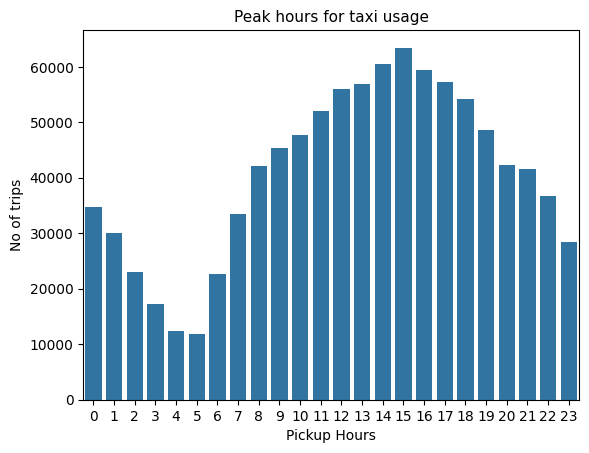

In [156]:
case1 = df.groupby(['pickup_hour']).size().reset_index().rename(columns = {0 : 'total_trips'}).sort_values(by = ['total_trips'])
sns.barplot(data = case1, x = 'pickup_hour', y = 'total_trips')
 
plt.xlabel('Pickup Hours')
plt.ylabel('No of trips')
plt.title('Peak hours for taxi usage', fontdict={"fontsize": 11})
plt.savefig('../reports/figures/peak_hours.png', bbox_inches='tight')
plt.show()

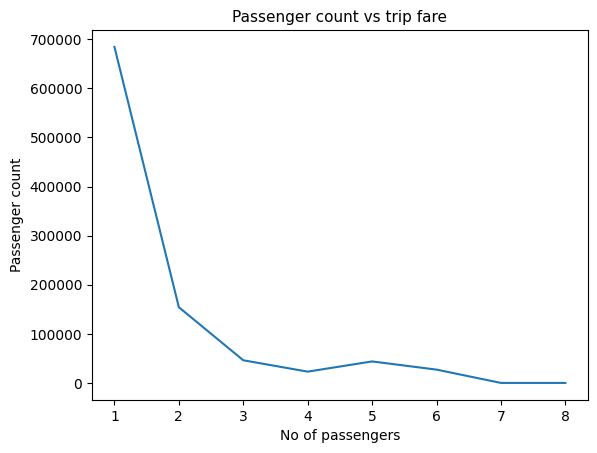

In [177]:
# passanger count vs trip fare
case2 = df.groupby(['passenger_count']).size().reset_index().rename(columns = {0: 'total_passenger'})

sns.lineplot(data = case2, x = 'passenger_count', y = 'total_passenger')
plt.xlabel('No of passengers')
plt.ylabel('Passenger count')
plt.title('Passenger count vs trip fare', fontdict={"fontsize": 11})
plt.savefig('../reports/figures/pass_vs_fare.png', bbox_inches='tight')
plt.show()

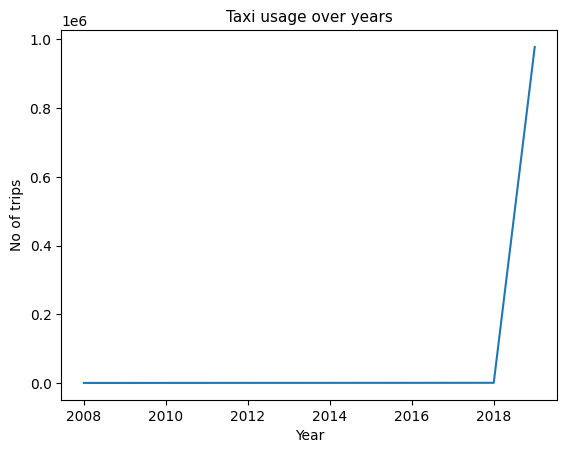

In [176]:
# trends in usage over the year?
case3 = df.groupby(['pickup_year']).size().reset_index().rename(columns = {0: 'total_trips'})

sns.lineplot(data = case3, x = 'pickup_year', y = 'total_trips')
plt.xlabel('Year')
plt.ylabel('No of trips')
plt.title('Taxi usage over years', fontdict={"fontsize": 11})
plt.savefig('../reports/figures/taxi_usage.png', bbox_inches='tight')
plt.show()